# Group 19: Milestone 1

## Library Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np

In [2]:
import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

## Load the combined data

In [3]:
%load_ext memory_profiler

In [4]:
%%time
%%memit
# Default float64 dtypes
df = pd.read_csv("figsharerainfall/combined_data.csv", index_col=0, parse_dates=True)

peak memory: 3329.23 MiB, increment: 3068.07 MiB
CPU times: user 1min 21s, sys: 24.1 s, total: 1min 45s
Wall time: 2min 23s


### Method 4: Load just columns what we want (for the following specific EDA)

In [5]:
%%time
%%memit
use_cols = ['lat_max', 'lon_max', 'rain (mm/day)', 'model']
df = pd.read_csv("figsharerainfall/combined_data.csv", usecols=use_cols)
df.head()

peak memory: 2596.45 MiB, increment: 2221.78 MiB
CPU times: user 43.3 s, sys: 8.83 s, total: 52.1 s
Wall time: 59.6 s


### EDA in Python

In [6]:
lon_max_df = df.groupby("lon_max").mean()[["rain (mm/day)"]].reset_index()
lat_max_df = df.groupby("lat_max").mean()[["rain (mm/day)"]].reset_index()
lon_lat_df = df.groupby(["lat_max", "lon_max"]).mean()[["rain (mm/day)"]].reset_index()

In [7]:
import altair as alt
# alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

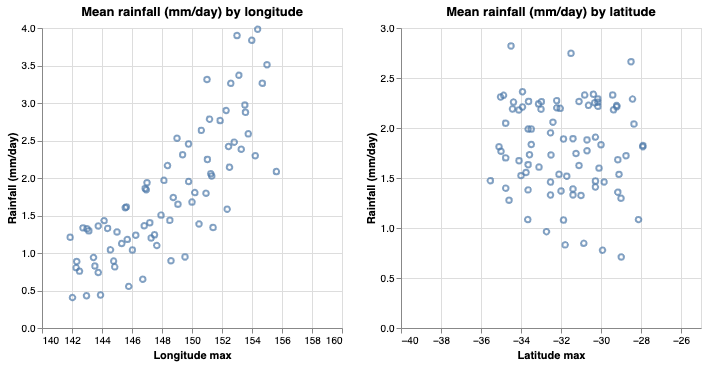

In [8]:
lon_max_eda = (
    alt.Chart(lon_max_df, title="Mean rainfall (mm/day) by longitude")
    .mark_point()
    .encode(
        x=alt.X("lon_max", scale=alt.Scale(domain=(140, 160)), title="Longitude max"),
        y=alt.Y("rain (mm/day)", title="Rainfall (mm/day)"),
    )
).properties(width=300)
lat_max_eda = (
    alt.Chart(lat_max_df, title="Mean rainfall (mm/day) by latitude")
    .mark_point()
    .encode(
        x=alt.X("lat_max", scale=alt.Scale(domain=(-40, -25)), title="Latitude max"),
        y=alt.Y("rain (mm/day)", title="Rainfall (mm/day)"),
    )
).properties(width=300)
lon_max_eda | lat_max_eda

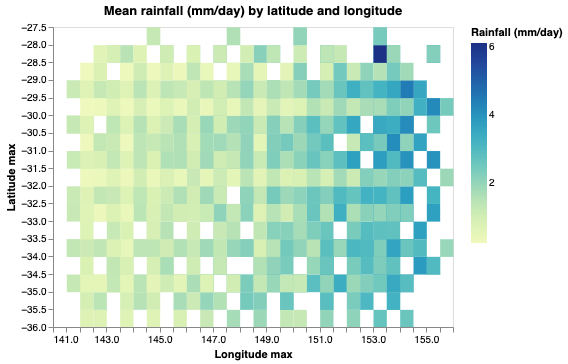

In [9]:
(alt.Chart(
    lon_lat_df,
    title=alt.TitleParams(
        text='Mean rainfall (mm/day) by latitude and longitude',
    )
).mark_rect().encode(
    alt.X('lon_max', bin=alt.Bin(maxbins=40), title='Longitude max'), 
    alt.Y('lat_max', bin=alt.Bin(maxbins=40), title='Latitude max'),
    alt.Color('rain (mm/day)', title='Rainfall (mm/day)')))

<!--  -->

## EDA in R

In [10]:
%load_ext rpy2.ipython

### Transfer the dataframe from python to R using Apache Arrow

In [11]:
%%time
%%memit
dataset = ds.dataset("figsharerainfall/combined_data.csv", format="csv")
table = dataset.to_table()
r_table = pyra.converter.py2rpy(table)

peak memory: 2982.81 MiB, increment: 815.95 MiB
CPU times: user 1min, sys: 4.95 s, total: 1min 5s
Wall time: 1min 5s


In [12]:
%%time
%%R -i r_table

start_time <- Sys.time()
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
lon_max_df <- r_table |> 
    group_by(lon_max) |> 
    summarize(mean_rainfall = mean(`rain (mm/day)`)) |> 
    collect()
lat_max_df <- r_table |> 
    group_by(lat_max) |> 
    summarize(mean_rainfall = mean(`rain (mm/day)`)) |> 
    collect()
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 6.145427 secs
CPU times: user 11.8 s, sys: 2.26 s, total: 14 s
Wall time: 6.2 s


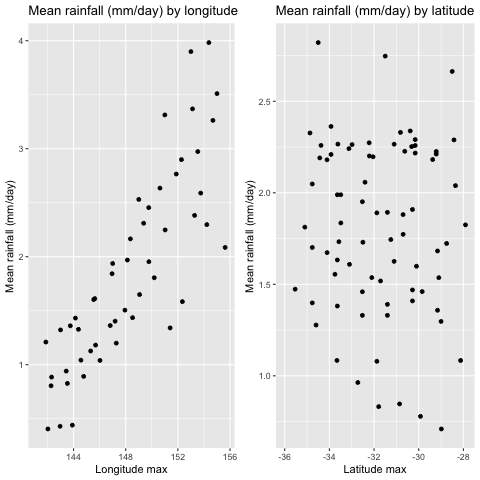

In [13]:
%%R
suppressMessages(library(cowplot))
lon_max_eda <- lon_max_df |> 
    ggplot(aes(x = lon_max, y = mean_rainfall)) + 
    geom_point() +
    ggtitle("Mean rainfall (mm/day) by longitude") +
    labs(x = "Longitude max", y = "Mean rainfall (mm/day)")
lat_max_eda <- lat_max_df |> 
    ggplot(aes(x = lat_max, y = mean_rainfall)) + 
    geom_point() +
    ggtitle("Mean rainfall (mm/day) by latitude") +
    labs(x = "Latitude max", y = "Mean rainfall (mm/day)")
plot_grid(lon_max_eda, lat_max_eda)